In [1]:
import numpy as np
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape, Activation
from keras.layers import Input, BatchNormalization
from keras.losses import mean_squared_error
from keras.optimizers import Adam

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.cifar import dataGenerator

# Parameters

In [2]:
num_class = 10
input_shape = (32, 32, 3)
m_train = 50000
m_test = 10000

batch_size = 32

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [3]:
trainGenerator = dataGenerator('train', batch_size=batch_size, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size)

# Model

In [4]:
x = Input(shape=input_shape)
y = Input(shape=(num_class,))

encoder = Convolution2D(filters=128, kernel_size=(5, 5)) (x)
encoder = BatchNormalization() (encoder)
encoder = Activation('relu') (encoder)
encoder = PrimaryCaps(capsules=12, capsule_dim=8, kernel_size=(5, 5), strides=2, activation='relu', activation_caps=squash) (encoder)
encoder = Caps(capsules=10, capsule_dim=8, routings=3, activation_caps=squash) (encoder)

output = ClassesCaps(name='capsule') (encoder)

decoder = Mask() (encoder, y_true=y)
decoder = Dense(512, activation='relu') (decoder)
decoder = Dense(1024, activation='relu') (decoder)
decoder = Dense(3072, activation='sigmoid') (decoder)
decoder = Reshape((input_shape), name='reconstruction') (decoder)

model_training = Model(inputs=[x, y], outputs=[output, decoder])
model = Model(inputs=x, outputs=output)

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       9728      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 128)       0         
_________________________________________________________________
primary_caps_1 (PrimaryCaps) (None, 1728, 8)           307296    
_________________________________________________________________
caps_1 (Caps)                (None, 10, 8)             1105920   
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total para

# Training

In [6]:
model_training.compile(loss=[margin(), mean_squared_error],
                        loss_weights=[1, 0.0005],
                        optimizer=Adam(lr=1e-4),
                        metrics={'capsule': 'accuracy'})

model.compile(optimizer=Adam(), loss=margin(), metrics=['accuracy'])

In [7]:
history = LossHistory(metrics=('loss', 'capsule_loss', 'reconstruction_loss', 'capsule_acc'))
hist = model_training.fit_generator(trainGenerator,
                                    steps_per_epoch=m_train // batch_size,
                                    epochs=20,
                                    validation_data=testGenerator,
                                    validation_steps=m_test // batch_size,
                                    verbose=2,
                                    callbacks=[history])

Epoch 1/20
 - 252s - loss: 0.3771 - capsule_loss: 0.3771 - reconstruction_loss: 0.0640 - capsule_acc: 0.4546 - val_loss: 0.3366 - val_capsule_loss: 0.3365 - val_reconstruction_loss: 0.0636 - val_capsule_acc: 0.5306
Epoch 2/20
 - 253s - loss: 0.3104 - capsule_loss: 0.3103 - reconstruction_loss: 0.0638 - capsule_acc: 0.5784 - val_loss: 0.3209 - val_capsule_loss: 0.3209 - val_reconstruction_loss: 0.0634 - val_capsule_acc: 0.5507
Epoch 3/20
 - 253s - loss: 0.2771 - capsule_loss: 0.2771 - reconstruction_loss: 0.0637 - capsule_acc: 0.6399 - val_loss: 0.2960 - val_capsule_loss: 0.2960 - val_reconstruction_loss: 0.0632 - val_capsule_acc: 0.6099
Epoch 4/20
 - 254s - loss: 0.2576 - capsule_loss: 0.2576 - reconstruction_loss: 0.0635 - capsule_acc: 0.6763 - val_loss: 0.2906 - val_capsule_loss: 0.2906 - val_reconstruction_loss: 0.0631 - val_capsule_acc: 0.6201
Epoch 5/20
 - 252s - loss: 0.2428 - capsule_loss: 0.2427 - reconstruction_loss: 0.0632 - capsule_acc: 0.7011 - val_loss: 0.2639 - val_capsul

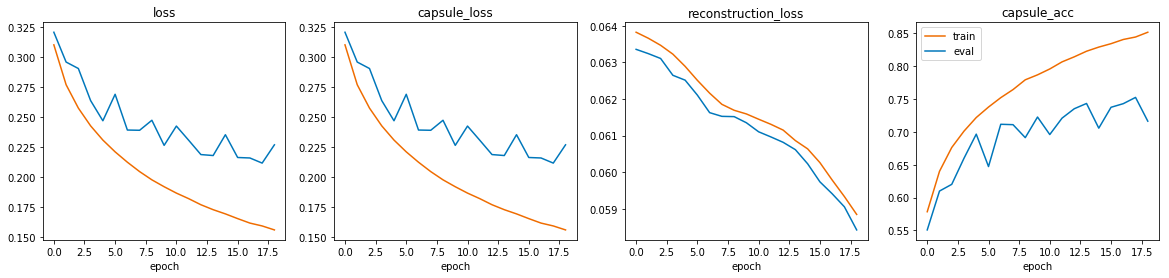

In [8]:
plotHistory(history.metrics)

# Training visualization

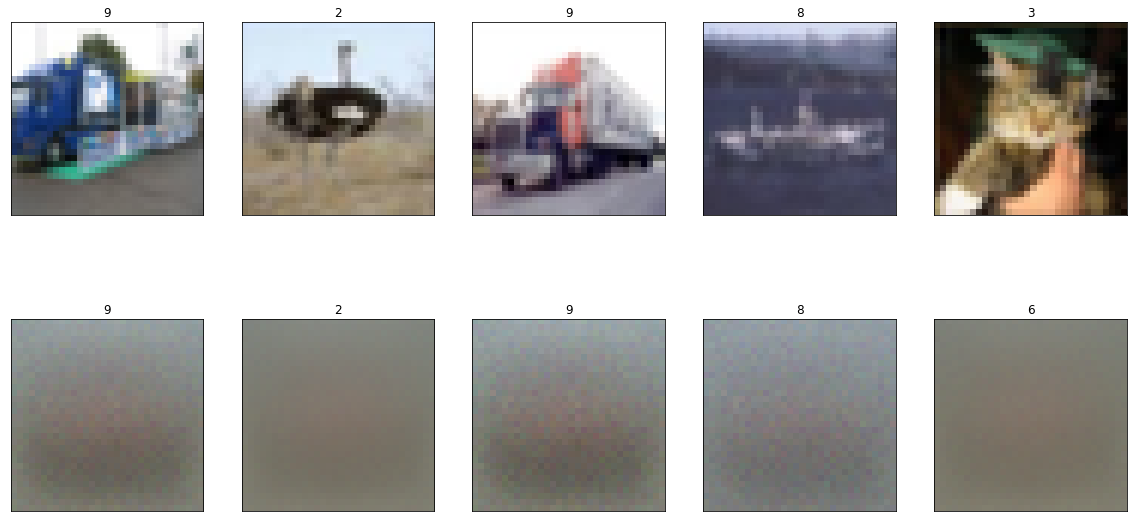

In [9]:
n_image = 5

# Select data
images, labels = next(dataGenerator('test', batch_size=n_image, reshape=False))

# Run inference
classes, reconstructions = model_training.predict([images, labels])

# Post-process data
labels = np.argmax(labels, axis=1)
predictions = np.argmax(classes, axis=1)

visualization_train((images, labels), (reconstructions, predictions))

# Evaluation on augmented data

## Accuracy
Test accuracy for different rotations on test data

Test acc [0.0°]:	0.718
Test acc [20.0°]:	0.671
Test acc [40.0°]:	0.566
Test acc [60.0°]:	0.477
Test acc [80.0°]:	0.428
Test acc [100.0°]:	0.394
Test acc [120.0°]:	0.362
Test acc [140.0°]:	0.353
Test acc [160.0°]:	0.339
Test acc [180.0°]:	0.331


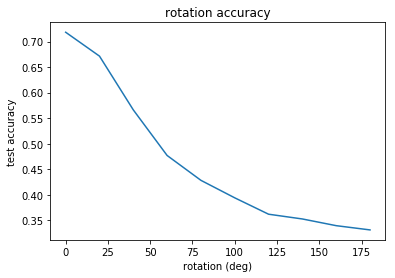

In [10]:
rotation_accuracy(model, dataGenerator, m_test=m_test, batch_size=batch_size)

## Visualization

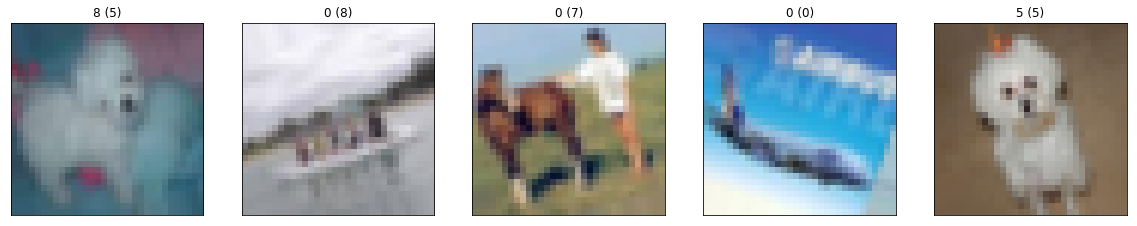

In [12]:
n_image=5
data_augmentation = {'rotation_range': 30}

# Select data
testGenerator = dataGenerator('test', batch_size=n_image, reshape=False, **data_augmentation)
images, labels = next(testGenerator)

# Run inference
predictions = model.predict(images)

# Post-process data
labels = np.argmax(labels, axis=1)
predictions = np.argmax(predictions, axis=1)

visualization_data(images, labels, predictions)